Sending ind: [0.4111591795001075, 0.10002356393722989, 0.43467034611335087, 0.15036006048321982]
Waiting Result
###### GENERATION 1 ######


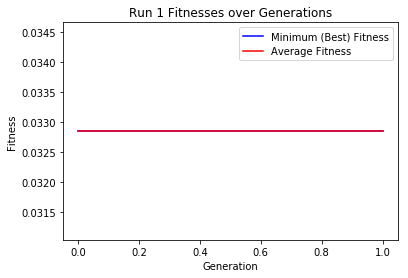

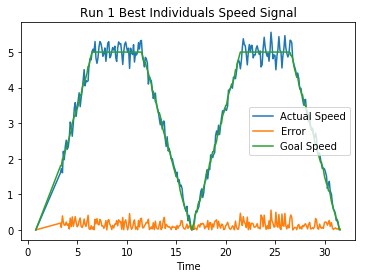

In [22]:
# DEAP EA
#    EA for PID tuning Experiment on Autorally
#    
#
# GAS 09-11-18



%matplotlib inline
# For command line argument parsing
import argparse

# For communication with evo_ros2
import zmq

# For data / fitness evaluation
import pandas as pd
from sklearn.metrics import mean_squared_error

# For DEAP
import random
from deap import creator, base, tools, algorithms
import numpy as np

# For email notifications
import smtplib
from email.mime.text import MIMEText

# For showing DEAP plots
import matplotlib.pyplot as plt
import networkx

# For EA running time
import time

# For creating directories and saving logs
import os
from os import listdir
from os.path import isfile, join
import json
import collections
import datetime

# For saving plots
import pickle



class DEAP_EA():
    def __init__(self, cmd_args):
        self.debug = cmd_args.debug
        
        # EA Params
        self.experiment_name = "PID-Tuning"
        self.run_number = 1
        self.genome_size = 4
        self.tourn_size = 2
        self.pop_size = 1
        self.number_generations = 1
        
        
        # Socket Communication Params      
        self.ip_addr = '127.0.0.1'
        self.send_port = 5022
        self.recv_port = 5032

        # Email Notification Params
        self.email_receiver_list = ['glen.a.simon@gmail.com']
        
        
        try:
             # Set up 
            self.detailed_log = dict()
            self.set_up_EA()
            self.set_up_sockets()
            self.set_up_dirs()
        
            # Run
            self.start_time = time.time()
            self.run()
        finally:
            self.socket.close()
            self.receiver.close()
            self.context.destroy()
        
    
    
    ### Run the EA ###
    def run(self):
        self.population = self.toolbox.population(n=self.pop_size)
        self.history.update(self.population)

        self.ending_pop, self.summary_log = self.eaSimpleCustom(cxpb=0.5, mutpb=0.2)
        self.end_time = time.time()
        

        # Final logging and notifications
        self.create_run_log()
        self.write_run_log()
        self.create_run_plots()
        self.email_notification(json.dumps(self.run_log, indent=2))
    
    
    def eaSimpleCustom(self, cxpb, mutpb):
        population = self.population
        toolbox = self.toolbox
        stats=self.stats
        halloffame=self.hof
        ngen = self.number_generations
        
        self.gen = 0
        
        logbook = tools.Logbook()
        logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in population if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        if halloffame is not None:
            halloffame.update(population)

        record = stats.compile(population) if stats else {}
        logbook.record(gen=0, nevals=len(invalid_ind), **record)

        # Begin the generational process
        for gen in range(1, ngen + 1):
            print('###### GENERATION {} ######'.format(gen))
            self.gen = gen
            
            # Select the next generation individuals
            offspring = toolbox.select(population, len(population))

            # Vary the pool of individuals
            offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

            # Evaluate the individuals with an invalid fitness
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit

            # Update the hall of fame with the generated individuals
            if halloffame is not None:
                halloffame.update(offspring)

            # Replace the current population by the offspring
            population[:] = offspring

            # Append the current generation statistics to the logbook
            record = stats.compile(population) if stats else {}
            logbook.record(gen=gen, nevals=len(invalid_ind), **record)

        return population, logbook
        
        
    ### Set up evaluation function ###
    def evaluate_ind(self, ind):
        print('Sending ind: {}'.format(ind))
        self.socket.send_json(ind)
        
        print('Waiting Result')
        result = self.receiver.recv_json()
        
        #print('Recv\'d Result')
        df = pd.DataFrame.from_dict(dict(result))
        df['Error'] = abs(df['Actual Speed'] - df['Goal Speed'])
        #df.plot(x='Time')
        fitness = mean_squared_error(df['Actual Speed'],  df['Goal Speed'])
        #print('Fitness: {}'.format(fitness))
        
        
        
        # add individual to detailed log
        if str(ind) not in self.detailed_log.keys():
            self.detailed_log[str(ind)] = {
                "gen": self.gen,
                "fitness": fitness,
                "dataFrame": df.to_json()
            }
            
            
        return (fitness, )
    
    
    ### Set up individual's shape, fitness function, and EA operators ###
    def set_up_EA(self):
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        self.toolbox = base.Toolbox()
        self.toolbox.register("attr_float", random.random)
        self.toolbox.register("individual", tools.initRepeat, creator.Individual,
                 self.toolbox.attr_float, n=self.genome_size)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        
        # Set up Evo Algo operators
        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
        self.toolbox.register("select", tools.selTournament, tournsize=self.tourn_size)
        self.toolbox.register("evaluate", self.evaluate_ind)
        
        # Set up EA history
        self.history = tools.History()
        
        # Decorate the variation operators
        self.toolbox.decorate("mate", self.history.decorator)
        self.toolbox.decorate("mutate", self.history.decorator)
        
        # Set up hall of fame and statistics
        self.hof = tools.HallOfFame(10)
        self.stats = tools.Statistics(lambda ind: ind.fitness.values)
        self.stats.register("avg", np.mean)
        self.stats.register("std", np.std)
        self.stats.register("min", np.min)
        self.stats.register("max", np.max)


    ### Set up communication sockets ###
    def set_up_sockets(self):
        #Initialize the socket for data
        
        # Setup the socket to send data out on.
        self.context = zmq.Context()
        self.socket = self.context.socket(zmq.PUSH)
        #socket.setsockopt(zmq.LINGER, 0)    # discard unsent messages on close
        self.socket.bind('tcp://{}:{}'.format(self.ip_addr, self.send_port))

        # Setup the socket to read the responses on.
        self.receiver = self.context.socket(zmq.PULL)
        self.receiver.bind('tcp://{}:{}'.format(self.ip_addr, self.recv_port))

        # Setup ZMQ poller
        self.poller = zmq.Poller()
        self.poller.register(self.receiver, zmq.POLLIN)
       
    
    
    ### Email notification ###
    def email_notification(self, results):
        sender = 'evo.ros2.result.sender@gmail.com'
        msg = MIMEText(str(results))
        msg['From'] = sender
        msg['To'] = str(self.email_receiver_list)
        msg['Subject'] = 'EA Results'
    
        HOST = "smtp.gmail.com"
        PORT = "587"
        SERVER = smtplib.SMTP()
        SERVER.connect(HOST, PORT)
        USER = "evo.ros2.result.sender@gmail.com"
        PASSWD = "evoRos2Rocks"
        SERVER.ehlo()
        SERVER.starttls()
        SERVER.login(USER,PASSWD)

        #SERVER.set_debuglevel(True)
        SERVER.sendmail(sender, self.email_receiver_list, msg.as_string())
        SERVER.quit()

    
    ### Create Experiment and Run directories if not already made ###
    def set_up_dirs(self):
        
        # Make sure that a directory for this experiment has been made
        self.experiment_directory = 'logs/' + self.experiment_name
        if not os.path.isdir(self.experiment_directory):
            print('No directory for experiment...Creating now.')
            os.makedirs(self.experiment_directory)
            
        # Make sure that a directory for this run has been made
        self.run_directory = self.experiment_directory + '/run' + str(self.run_number)
        if not os.path.isdir(self.run_directory):
            print('No directory for run...Creating now.')
            os.makedirs(self.run_directory)
            
    ### Create the run log ###
    def create_run_log(self):
        self.run_log = collections.OrderedDict()
        
        self.hof_fitnesses = list()
        for ind in self.hof:
            self.hof_fitnesses.append(ind.fitness.values)
        
        self.run_log['experiment_name'] = self.experiment_name
        self.run_log['run_number'] = self.run_number
        self.run_log['run_date'] = str(datetime.datetime.now())
        self.run_log['running_time'] = (self.end_time - self.start_time)
        self.run_log['best_ind'] = self.hof[0]
        self.run_log['best_ind_fitness'] = self.hof[0].fitness.values
        self.run_log['summary_log'] = self.summary_log
        self.run_log['hall_of_fame'] = list(self.hof)
        self.run_log['hall_of_fame_fitnesses'] = self.hof_fitnesses
        self.run_log['detailed_log'] = self.detailed_log
        
        
    ### Write the run log to disk ###
    def write_run_log(self):
        with open(self.run_directory + '/log' + '.json', 'w+') as outfile:
            json.dump(self.run_log, outfile, indent=2)
        
        
    ### Create run plots ###
    def create_run_plots(self):
        
        # Fitnesses of Population over Generations
        gen = self.summary_log.select("gen")
        avg_fit = self.summary_log.select("avg")
        best_fit = self.summary_log.select("min")


        fig, ax1 = plt.subplots()
        line1 = ax1.plot(gen, best_fit, "b-", label="Minimum (Best) Fitness")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Fitness")
        line2 = ax1.plot(gen, avg_fit, "r-", label="Average Fitness")
        lns = line1 + line2
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc="best")
        ax1.set_title('Run {} Fitnesses over Generations'.format(self.run_number))

        #plt.show()
        plt.savefig('{}/fitness_graph.png'.format(self.run_directory), bbox_inches='tight')
        
        
        # Speed Signal of Best Ind
        details_of_best_ind = self.detailed_log[str(self.hof[0])]
        self.df = pd.read_json(details_of_best_ind['dataFrame'], orient='columns')
        self.df = self.df.sort_index()
        ax2 = self.df.plot(x='Time')
        ax2.legend(loc="best")
        ax2.set_title('Run {} Best Individuals Speed Signal'.format(self.run_number))
        fig2 = ax2.get_figure()
        fig2.savefig('{}/best_ind_speed_plot.png'.format(self.run_directory), bbox_inches='tight')
        
    
    
    def print_genealogy_tree(self):
        graph = networkx.DiGraph(self.history.genealogy_tree)
        graph = graph.reverse()     # Make the grah top-down
        print(graph)
        colors = [self.toolbox.evaluate(self.history.genealogy_history[i])[0] for i in graph]
        networkx.draw(graph, node_color=colors)
        plt.show()

if __name__ == '__main__':
    # Parse arguments
    parser = argparse.ArgumentParser(description='Front end DEAP EA for PID Study')
    parser.add_argument('-d', '--debug', action='store_true', help='Print extra output to terminal.')
    args, unknown = parser.parse_known_args() # Only parse arguments defined above

    node = DEAP_EA(cmd_args = args)